In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantstats as qs
from scipy.stats import zscore
from scipy.stats import norm
import matplotlib.pyplot as plt

In [25]:
market = pd.read_csv("TWII(15y).csv", parse_dates=['年月日'])
all = pd.read_csv("all_stocks(15y).csv", encoding="utf-8", sep=',', parse_dates=['年月日'])
pc_ratio = pd.read_csv("taifex_put_call_ratio (15y).csv", parse_dates=['日期'])
pc_ratio

,日期,買權成交量,賣權成交量,買賣權成交量比率%,買權未平倉量,賣權未平倉量,買賣權未平倉量比率%
0,2010-01-29,296656,312668,94.88,398389,509058,78.26
1,2010-01-28,192339,257877,74.59,398847,470973,84.69
2,2010-01-27,217839,226565,96.15,367062,465755,78.81
3,2010-01-26,384306,395599,97.15,344220,433470,79.41
4,2010-01-25,178681,174070,102.65,356861,372845,95.71
...,...,...,...,...,...,...,...
3832,2025-08-15,396787,398023,99.69,140402,114629,122.48
3833,2025-08-14,222646,228348,97.50,158098,144430,109.46
3834,2025-08-13,619432,589737,105.04,119082,102348,116.35
3835,2025-08-12,235814,249185,94.63,185019,156236,118.42


In [26]:
all = all.rename(columns={'證券代碼': 'code', '年月日': 'date', '收盤價(元)': 'close', '成交量(千股)': 'volume'})

# Stock Price Strength 分項

In [27]:
df = all.copy()
total_stocks = df['code'].nunique()
total_days = df['date'].nunique()
print(f'總個股數{total_stocks}, 總交易天數{total_days}, 總資料筆數{total_stocks*total_days}')

# 計算過去52週（252個交易日）的最高價與最低價（不包含當日）
df['rolling_max'] = df.groupby('code')['close'].transform(lambda x: x.shift(1).rolling(window=252, min_periods=252).max())
df['rolling_min'] = df.groupby('code')['close'].transform(lambda x: x.shift(1).rolling(window=252, min_periods=252).min())

# 判斷當日是否創新高/新低
df['new_high'] = df['close'] > df['rolling_max']
df['new_low'] = df['close'] < df['rolling_min']
df = df.dropna()

# 計算每日創新高、新低比例
daily_stats = df.groupby('date').agg(
    new_high_count=('new_high', 'sum'),
    new_low_count=('new_low', 'sum'),
    stocks = ('code', 'count')
).reset_index()


# 計算創新高比例 - 創新低比例
daily_stats['high_minus_low'] = daily_stats['new_high_count'] - daily_stats['new_low_count']
daily_stats['percentage'] = (daily_stats['high_minus_low']/ daily_stats['stocks']) *100

# 計算分數方式 (過去三年約756個交易日依比例給分)
daily_stats['score'] = (daily_stats['percentage'].shift(1).rolling(window=756, min_periods=756).apply(lambda x: x.rank(pct=True).iloc[-1] * 100, raw=False))
daily_stats.dropna(inplace= True)



總個股數1149, 總交易天數3679, 總資料筆數4227171


In [28]:
daily_stats

,date,new_high_count,new_low_count,stocks,high_minus_low,percentage,score
756,2014-09-23,5,19,910,-14,-1.538462,15.211640
757,2014-09-24,5,11,910,-6,-0.659341,19.841270
758,2014-09-25,2,47,910,-45,-4.945055,26.984127
759,2014-09-26,2,76,910,-74,-8.131868,7.407407
760,2014-09-29,3,54,910,-51,-5.604396,4.365079
...,...,...,...,...,...,...,...
3422,2025-08-25,27,11,1030,16,1.553398,16.798942
3423,2025-08-26,30,24,1030,6,0.582524,58.796296
3424,2025-08-27,29,17,1030,12,1.165049,41.269841
3425,2025-08-28,25,13,1030,12,1.165049,52.579365


# Market Momentum分項

In [29]:
#market = market.drop(columns="證券代碼", axis=1)
market = market.rename(columns={'年月日': 'date', '收盤價(元)': 'close'})

market['MA125'] = market['close'].rolling(125).mean()
market = market.dropna()
market['Momentum_diff'] = (market['close'] - market['MA125'])/ market['MA125']

#market['score'] = market['Momentum_diff'].rank(pct=True) * 100
market['score'] = (market['Momentum_diff'].shift(1).rolling(window=756, min_periods=756).apply(lambda x: x.rank(pct=True).iloc[-1] * 100, raw=False))
market.dropna(inplace= True)

market


,證券代碼,date,close,MA125,Momentum_diff,score
880,Y9999 加權指數,2014-03-20,8597.33,8424.48128,0.020517,69.841270
881,Y9999 加權指數,2014-03-21,8577.17,8427.75304,0.017729,56.084656
882,Y9999 加權指數,2014-03-24,8605.38,8431.45624,0.020628,53.835979
883,Y9999 加權指數,2014-03-25,8689.30,8434.92792,0.030157,56.349206
884,Y9999 加權指數,2014-03-26,8737.27,8438.82784,0.035365,67.328042
...,...,...,...,...,...,...
3674,Y9999 加權指數,2025-08-25,24277.38,22003.92320,0.103321,76.587302
3675,Y9999 加權指數,2025-08-26,24305.10,22012.07824,0.104171,86.640212
3676,Y9999 加權指數,2025-08-27,24519.90,22021.01704,0.113477,86.772487
3677,Y9999 加權指數,2025-08-28,24236.45,22030.48320,0.100132,89.153439


# Stock Price Breadth 分項


In [30]:
# 
df2 = all.copy()
df2['past_price'] = df2.groupby('code')['close'].transform(lambda x: x.shift(1))

df2['pos'] = df2['close'] >= df2['past_price']

pos_volume = df2[df2["pos"] == True].groupby("date")["volume"].sum().reset_index(name= 'pos_volume')
neg_volume = df2[df2["pos"] == False].groupby("date")["volume"].sum().reset_index(name= 'neg_volume')

daily_volume_stats = pd.merge(pos_volume, neg_volume, on="date", how="outer").fillna(0)
daily_volume_stats = daily_volume_stats.iloc[1:]  # 移除第一行，因為那天沒有前一天的數據
daily_volume_stats['ratio'] = daily_volume_stats['pos_volume']/ daily_volume_stats['neg_volume']

daily_volume_stats['zscore'] = zscore(daily_volume_stats['ratio'])

#daily_volume_stats['score'] = norm.cdf(daily_volume_stats["zscore"]) * 100
#daily_volume_stats['score'] = daily_volume_stats['ratio'].rank(pct=True) * 100

daily_volume_stats['score'] = (daily_volume_stats['ratio'].shift(1).rolling(window=756, min_periods=756).apply(lambda x: x.rank(pct=True).iloc[-1] * 100, raw=False))

daily_volume_stats.dropna(inplace= True)
daily_volume_stats




,date,pos_volume,neg_volume,ratio,zscore,score
757,2013-09-14,468696.0,608227,0.770594,-0.319870,24.735450
758,2013-09-16,1710746.0,250669,6.824721,0.921399,28.042328
759,2013-09-17,1064606.0,641681,1.659089,-0.137703,94.179894
760,2013-09-18,1232148.0,720353,1.710478,-0.127167,55.423280
761,2013-09-23,1924741.0,474123,4.059582,0.354467,57.142857
...,...,...,...,...,...,...
3674,2025-08-25,3101896.0,777556,3.989290,0.340055,32.275132
3675,2025-08-26,2552806.0,2670578,0.955900,-0.281876,90.343915
3676,2025-08-27,2883340.0,1204915,2.392982,0.012766,33.068783
3677,2025-08-28,2472878.0,1682646,1.469637,-0.176546,73.412698


# Put/Call Options 分項

In [31]:
# 
pc_ratio = pc_ratio.sort_values(by='日期', ascending=True).reset_index()
pc_ratio = pc_ratio[['日期', '買賣權未平倉量比率%']]
pc_ratio = pc_ratio.rename(columns={'日期':'date', '買賣權未平倉量比率%':'Putcall ratio'})


pc_ratio['ma5'] = pc_ratio['Putcall ratio'].rolling(5).mean()
pc_ratio = pc_ratio.dropna().reset_index(drop=True)


#pc_ratio['score'] = pc_ratio['ma5'].rank(pct=True, ascending= False) * 100
pc_ratio['score'] = (pc_ratio['ma5'].shift(1).rolling(window=756, min_periods=756).apply(lambda x: x.rank(pct=True).iloc[-1] * 100, raw=False))
pc_ratio = pc_ratio.dropna().reset_index(drop=True)

pc_ratio

,date,Putcall ratio,ma5,score
0,2013-01-18,98.26,103.132,60.185185
1,2013-01-21,98.93,100.420,52.910053
2,2013-01-22,104.80,100.016,46.428571
3,2013-01-23,103.42,100.150,46.031746
4,2013-01-24,98.18,100.718,46.296296
...,...,...,...,...
3072,2025-08-19,127.70,122.910,86.507937
3073,2025-08-20,95.98,118.836,88.425926
3074,2025-08-21,116.98,120.340,83.994709
3075,2025-08-22,121.54,120.152,85.582011


# Market Volatility 分項


In [32]:
# 因為取得不了VIXTWN數據，所以用VIX代替
import yfinance as yf
from dateutil import parser

vix = yf.Ticker("^VIX")
hist = vix.history(interval="1d", start='2010-01-01', end='2025-08-25').reset_index()
hist['Date'] = pd.to_datetime(hist['Date']).dt.tz_localize(None) + pd.Timedelta(days=1)  # 調整為台灣時間，並移除時區資訊
hist['ma50'] = hist['Close'].rolling(50).mean()
hist = hist.dropna()

#hist['zscore'] = -zscore(hist['ma50'])
#hist['score'] = norm.cdf(hist["zscore"]) * 100
#hist['score'] = hist['ma50'].rank(pct=True, ascending= False) * 100

hist['score'] = (hist['ma50'].shift(1).rolling(window=756, min_periods=756).apply(lambda x: x.rank(pct=True).iloc[-1] * 100, raw=False))
hist.dropna(inplace= True)


hist



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma50,score
805,2013-03-19,13.470000,13.640000,12.57,13.36,0,0.0,0.0,13.5080,0.132275
806,2013-03-20,13.030000,15.400000,12.92,14.39,0,0.0,0.0,13.5192,0.132275
807,2013-03-21,13.180000,13.180000,12.30,12.67,0,0.0,0.0,13.4968,0.264550
808,2013-03-22,13.070000,14.210000,12.62,13.99,0,0.0,0.0,13.5042,0.132275
809,2013-03-23,13.340000,13.850000,13.19,13.57,0,0.0,0.0,13.4994,0.264550
...,...,...,...,...,...,...,...,...,...,...
3929,2025-08-19,15.730000,15.950000,14.95,14.99,0,0.0,0.0,16.9214,46.560847
3930,2025-08-20,15.230000,15.910000,14.76,15.57,0,0.0,0.0,16.8974,46.296296
3931,2025-08-21,15.950000,17.190001,15.57,15.69,0,0.0,0.0,16.8680,46.164021
3932,2025-08-22,15.720000,17.240000,15.65,16.60,0,0.0,0.0,16.8610,46.164021


# Safe Haven Demand 分項

In [33]:
twii = yf.Ticker("^TWII")
twii_hist = twii.history(interval='1d', start='2010-01-01', end= '2025-08-25').reset_index()
twii_hist = twii_hist[['Date', 'Close']]
twii_hist['Date'] = pd.to_datetime(twii_hist['Date']).dt.tz_localize(None)

us_bond = yf.Ticker("TLT")
us_bond_hist = us_bond.history(interval='1d', start='2010-01-01', end= '2025-08-25').reset_index()
us_bond_hist = us_bond_hist[['Date', 'Close']]
us_bond_hist['Date'] = pd.to_datetime(us_bond_hist['Date']).dt.tz_localize(None)

twii_hist = twii_hist.rename(columns={'Date':'date', 'Close':'TWII_Close'})
us_bond_hist = us_bond_hist.rename(columns={'Date':'date', 'Close':'US_Bond_Close'})
Safe_Haven_Demand = pd.merge(twii_hist, us_bond_hist, on='date', how='inner')
Safe_Haven_Demand['20d TWII Return'] = Safe_Haven_Demand['TWII_Close'].pct_change(20).shift(1)
Safe_Haven_Demand['20d US Bond Return'] = Safe_Haven_Demand['US_Bond_Close'].pct_change(20).shift(1)
Safe_Haven_Demand['20d Return'] = Safe_Haven_Demand['TWII_Close'].pct_change(20).shift(1) - Safe_Haven_Demand['US_Bond_Close'].pct_change(20).shift(1)
Safe_Haven_Demand = Safe_Haven_Demand.dropna()

#Safe_Haven_Demand['score'] = Safe_Haven_Demand['20d Return'].rank(pct=True) * 100
Safe_Haven_Demand['score'] = (Safe_Haven_Demand['20d Return'].shift(1).rolling(window=756, min_periods=756).apply(lambda x: x.rank(pct=True).iloc[-1] * 100, raw=False))
Safe_Haven_Demand.dropna(inplace= True)

Safe_Haven_Demand

,date,TWII_Close,US_Bond_Close,20d TWII Return,20d US Bond Return,20d Return,score
777,2013-04-12,7821.593750,87.338463,-0.022484,0.048239,-7.072265e-02,18.783069
778,2013-04-15,7763.494141,88.097679,-0.021649,0.056224,-7.787362e-02,21.031746
779,2013-04-16,7801.014160,87.374237,-0.029014,0.066513,-9.552673e-02,19.576720
780,2013-04-17,7809.034180,87.954391,-0.018953,0.060968,-7.992048e-02,14.814815
781,2013-04-18,7791.314453,88.169365,-0.014938,0.063030,-7.796789e-02,18.518519
...,...,...,...,...,...,...,...
3689,2025-08-18,24482.519531,85.823708,0.040685,0.017483,2.320197e-02,50.793651
3690,2025-08-19,24353.500000,86.321815,0.048926,0.005573,4.335247e-02,51.455026
3691,2025-08-20,23625.439453,86.511086,0.059404,0.005331,5.407325e-02,66.005291
3692,2025-08-21,23962.130859,86.082726,0.013156,0.013156,-5.430118e-07,71.957672


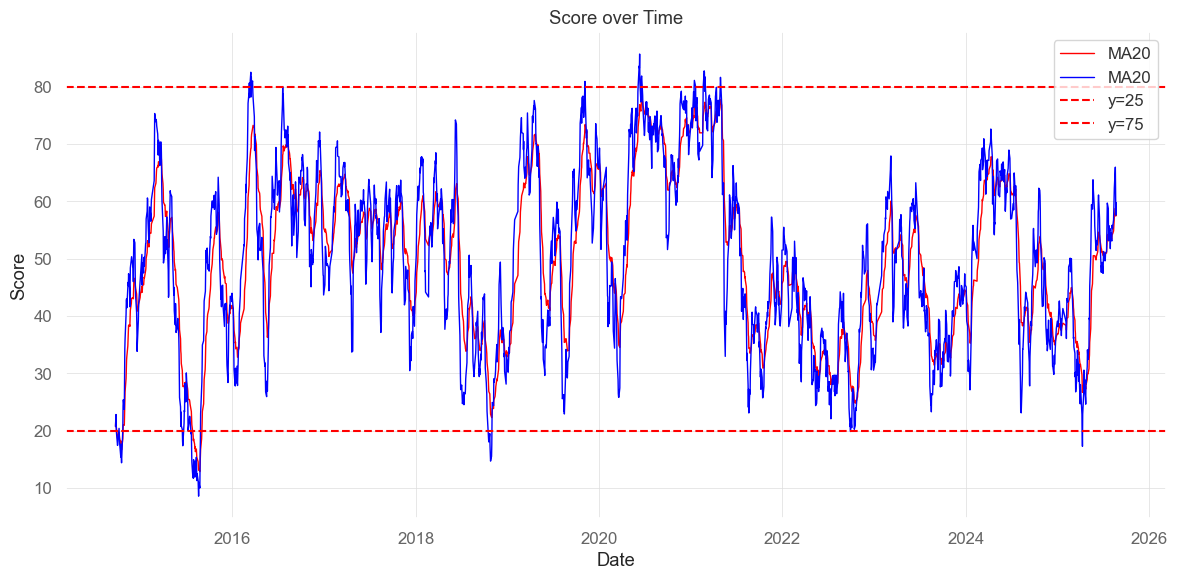

In [34]:
# Fear & Greed Index
market_score =  market[["date", "score"]].rename(columns={"score": "market_momentum"})
price_strength_score = daily_stats[["date", "score"]].rename(columns={"score": "stock_price_strength"})
price_breadth_score = daily_volume_stats[["date", "score"]].rename(columns={"score": "stock_price_breadth"})
put_call_score = pc_ratio[["date", "score"]].rename(columns={"score": "put_call_ratio"})
put_call_score['date'] = pd.to_datetime(put_call_score['date'])
vix_score = hist[["Date", "score"]].rename(columns={"Date": "date", "score": "volatility"})
safe_haven_score = Safe_Haven_Demand[["date", "score"]].rename(columns={"score": "safe_haven_demand"})

Index = pd.merge(market_score, price_strength_score , on="date", how="inner")
Index = pd.merge(Index, price_breadth_score , on="date", how="inner")
Index = pd.merge(Index, put_call_score , on="date", how="inner")
Index = pd.merge(Index, vix_score, on='date', how='inner')
Index = pd.merge(Index, safe_haven_score, on='date', how='inner')

Index['Fear_Greed_Index'] = (Index['market_momentum'] + Index['stock_price_strength'] + Index['stock_price_breadth']  + Index["volatility"] + Index['safe_haven_demand']
                             + Index['put_call_ratio']) / 6
Index['FGIEMA5'] = Index['Fear_Greed_Index'].ewm(span=5).mean()
Index['FGIEMA20']= Index['Fear_Greed_Index'].ewm(span=20).mean()

plt.figure(figsize=(12, 6))
#plt.plot(Index["date"], Index["market_momentum"], label="market_momentum")
#plt.plot(Index["date"], Index["stock_price_strength"], label="stock_price_strength")
#plt.plot(Index["date"], Index["stock_price_breadth"], label="stock_price_breadth")
#plt.plot(Index["date"], Index["put_call_ratio"], label="put_call_ratio", color='orange', linewidth=1)
#plt.plot(Index["date"], Index["volatility"], label="volatility", color='green', linewidth=1)
#plt.plot(Index["date"], Index["safe_haven_demand"], label="safe_haven_demand", color='purple', linewidth=1)
#plt.plot(Index["date"], Index["Fear_Greed_Index"], label="Fear_Greed_Index", color='blue', linewidth=1)
plt.plot(Index["date"], Index["FGIEMA20"], label="MA20", color='red', linewidth=1)
plt.plot(Index["date"], Index["FGIEMA5"], label="MA20", color='blue', linewidth=1)
plt.axhline(y=20, color='red', linestyle='--', label='y=25')
plt.axhline(y=80, color='red', linestyle='--', label='y=75')

plt.xlabel("Date")
plt.ylabel("Score")
plt.title("Score over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
Index

,date,market_momentum,stock_price_strength,stock_price_breadth,put_call_ratio,volatility,safe_haven_demand,Fear_Greed_Index,FGIEMA5,FGIEMA20
0,2014-09-23,29.365079,15.211640,7.671958,12.169312,9.126984,50.793651,20.723104,20.723104,20.723104
1,2014-09-24,26.719577,19.841270,21.296296,12.169312,9.523810,48.941799,23.082011,22.138448,21.961530
2,2014-09-25,27.116402,26.984127,30.687831,12.566138,9.788360,34.259259,23.567019,22.815140,22.551056
3,2014-09-26,23.412698,7.407407,4.232804,10.317460,10.052910,41.534392,16.159612,20.050536,20.705945
4,2014-09-30,21.428571,6.481481,16.534392,6.084656,10.449735,26.587302,14.594356,17.955984,19.227604
...,...,...,...,...,...,...,...,...,...,...
2011,2025-08-15,87.037037,57.142857,76.190476,80.158730,47.486772,52.380952,66.732804,62.322137,57.271465
2012,2025-08-19,89.153439,76.190476,89.417989,86.507937,46.560847,51.455026,73.214286,65.952853,58.789829
2013,2025-08-20,87.566138,22.288360,13.227513,88.425926,46.296296,66.005291,53.968254,61.957987,58.330631
2014,2025-08-21,74.735450,12.433862,3.835979,83.994709,46.164021,71.957672,48.853616,57.589863,57.428058


# TWII vs Fear&Greed Index

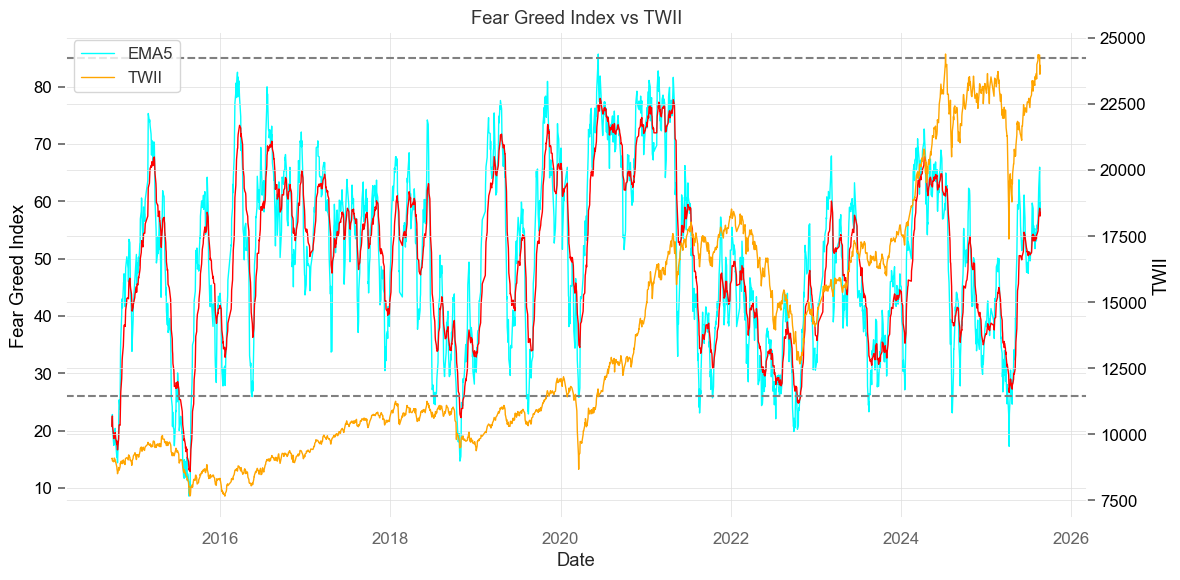

In [36]:
twii = yf.Ticker("^TWII")
twii_hist = twii.history(interval='1d', start='2009-08-01', end= '2025-08-25').reset_index()
twii_hist = twii_hist[['Date','Open', 'Close']]

twii_hist['Date'] = pd.to_datetime(twii_hist['Date']).dt.tz_localize(None)
twii_hist.rename(columns={'Date':'date'}, inplace=True)


mkt = pd.merge(twii_hist, Index, on='date', how='inner')
mkt

fig, ax1 = plt.subplots(figsize=(12, 6))

# 第一條線：Fear Greed Index
line1, = ax1.plot(mkt["date"], mkt["FGIEMA5"], label="EMA5", color='aqua', linewidth=1)
line3, = ax1.plot(Index["date"], Index["FGIEMA20"], label="MA20", color='red', linewidth=1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Fear Greed Index", color='black')
ax1.tick_params(axis='y', labelcolor='black')


# 第二條線：TWII
ax2 = ax1.twinx()
line2, = ax2.plot(mkt['date'], mkt['Close'], label='TWII', color='orange', linewidth=1)
ax2.set_ylabel("TWII", color='Black')
ax2.tick_params(axis='y', labelcolor='Black')

ax1.axhline(y=26, color='grey', linestyle='--', label='y=20')
ax1.axhline(y=85, color='grey', linestyle='--', label='y=80',)


lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title("Fear Greed Index vs TWII")
fig.tight_layout()
plt.grid(True)
#plt.legend()
plt.show()

# Backtest

In [37]:
# 技術指標定義
def RSI(df, period):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rsi = gain/(gain + loss) * 100
    return rsi

In [38]:
# 個股輸入
stock_hist = pd.read_csv("0050(10y).csv", parse_dates=['年月日'])
stock_hist = stock_hist.rename(columns={'年月日':'date', '開盤價(元)':'Open', '收盤價(元)':'Close'})
stock_hist = stock_hist[['date','Open', 'Close']]

stock_hist['date'] = pd.to_datetime(stock_hist['date'])

data = pd.merge(stock_hist, Index, on='date', how='inner')
data['RSI'] = RSI(data, period=14)
data = data.dropna().reset_index(drop=True)

In [39]:
from collections import deque

trade = data[['date', 'Open', 'Close', 'Fear_Greed_Index', 'RSI']].copy()
trade = trade[trade['date'] >= pd.to_datetime('2015-06-17')].copy().reset_index(drop=True)

# 初始化資料
start_cash = 1_500_000.00
cash = start_cash
cost = 0
position = 0
unit_shares = 1000
position_long_price = []
realized_return = 0

trade['Position'] = 0
trade['Entry Signal'] = 0
trade['Exit Signal'] = 0
trade['Entry Record'] = 0
trade['Exit Record'] = 0
trade['Cum Return'] = 0.0
trade['Unrealized_return'] = 0.0
trade['Realized_return'] = 0.0
trade['Total Cost'] = 0.0
trade['Equity'] = start_cash
trade['Cash'] = start_cash

entry_record_window = deque()  # 記錄近期進場的日期
entry_window = 30             
entry_limit = 800 # 幾天內最多只能進場幾次
overbuy_limited = False

# 最後紀錄每筆買賣
buy_dates = []
sell_dates = []
entry_price = []
exit_price = []

for i in range(1, len(trade)):
    pday = trade.iloc[i - 1]
    cday= trade.iloc[i]
    today = cday['date']
    
    # 短期進場次數限制
    entry_record_window = deque([d for d in entry_record_window if (today - d).days <= entry_window])
    if len(entry_record_window) >= entry_limit:
        overbuy_limited = True
        print(f" {today}達到短期進場上限，限制買入")
    else:
        overbuy_limited = False

    # 進出場signal: Fear & Greed Index & RSI:
    entry_signal = (cday['Fear_Greed_Index'] < 26) and (cday['RSI'] < 30)
    exit_signal = (cday['Fear_Greed_Index'] > 85) or (cday['RSI'] > 90)

    # 當日加碼
    if pday['Entry Signal'] == 1 and cash >= (cday['Open'] * unit_shares) and not overbuy_limited:
        trade.at[i,'Entry Record'] = 1
        position += unit_shares
        cost += cday['Open'] * unit_shares
        cost += cday['Open'] * unit_shares * 0.001425  # 交易手續費
        cash -= cday['Open'] * unit_shares
        position_long_price.append(cday['Open'])

        entry_record_window.append(today)
        buy_dates.append(today)
        entry_price.append(cday['Open'])
    elif pday['Entry Signal'] == 1 and cash < (cday['Open'] * unit_shares):
        print(f"{today} 資金不足無法買入。現有資金{cash}，標的價格{cday['Open'] * unit_shares}")

    # 當日減少持倉
    if  position > 0 and pday['Exit Signal'] == 1:
        position -= unit_shares
        trade.at[i, 'Exit Record'] = 1
        cash += cday['Open'] * unit_shares
        cost += (cday['Open'] * unit_shares * 0.001425) + (cday['Open'] * unit_shares * 0.003)  # 手續費+ 交易稅
        buy_price_tmp = position_long_price[0]
        position_long_price.pop(0)  # FIFO
        realized_return += (cday['Open'] - buy_price_tmp) * unit_shares
        sell_dates.append(today)
        exit_price.append(cday['Open'])

    elif i == len(trade) - 1 and position > 0:  # 最後一天全部賣出
        trade.at[i, 'Exit Record'] = 1
        cash += cday['Close'] * position
        for buy_price_tmp in position_long_price:
            realized_return += (cday['Close'] - buy_price_tmp) * unit_shares
            sell_dates.append(today)
            exit_price.append(cday['Close'])
        position = 0
    

    # 每日報酬率結算
    if i != len(trade)-1:
        unrealized_return = (cday['Close'] - sum(position_long_price)/len(position_long_price)) * position if position > 0 else 0
    else:
        unrealized_return = 0
    trade.at[i, 'Cum Return'] = (unrealized_return + realized_return) / cost if cost !=0 else 0


    # 訊號偵測
    if entry_signal:
        trade.at[i, 'Entry Signal'] = 1
    
    if exit_signal:
        trade.at[i, 'Exit Signal'] = 1

    
    trade.at[i, 'Position'] = position  # 紀錄每天收盤部位數量
    trade.at[i, 'Unrealized_return'] = unrealized_return
    trade.at[i, 'Realized_return'] = realized_return
    trade.at[i, 'Total Cost'] = cost
    trade.at[i, 'Equity'] = cash + (position * cday['Close'])
    trade.at[i, 'Cash'] = cash

    if i > 0:
        trade.at[i, 'DRE'] = (trade.at[i, 'Equity'] - trade.at[i-1, 'Equity']) / trade.at[i-1, 'Equity']
    else:
        trade.at[i, 'DRE'] = 0
#trade['CReturn_Eq'] =  (1+ trade['Equity'].pct_change()).cumprod() - 1
trade['CReturn_Eq'] =  trade['Equity'].pct_change().cumsum().fillna(0)
trade


2018-10-12 00:00:00 資金不足無法買入。現有資金49900.0，標的價格77700.0
2018-10-17 00:00:00 資金不足無法買入。現有資金49900.0，標的價格80450.0
2018-10-18 00:00:00 資金不足無法買入。現有資金49900.0，標的價格79500.0
2018-10-19 00:00:00 資金不足無法買入。現有資金49900.0，標的價格78200.0
2018-10-23 00:00:00 資金不足無法買入。現有資金49900.0，標的價格78100.0
2018-10-24 00:00:00 資金不足無法買入。現有資金49900.0，標的價格77800.0
2018-10-25 00:00:00 資金不足無法買入。現有資金49900.0，標的價格75500.0
2018-10-26 00:00:00 資金不足無法買入。現有資金49900.0，標的價格76250.0
2018-10-30 00:00:00 資金不足無法買入。現有資金49900.0，標的價格75800.0
2018-10-31 00:00:00 資金不足無法買入。現有資金49900.0，標的價格76600.0
2018-11-01 00:00:00 資金不足無法買入。現有資金49900.0，標的價格77850.0
2019-08-07 00:00:00 資金不足無法買入。現有資金56200.0，標的價格80150.0
2019-08-08 00:00:00 資金不足無法買入。現有資金56200.0，標的價格80050.0
2020-03-24 00:00:00 資金不足無法買入。現有資金40600.0，標的價格73850.0
2023-08-23 00:00:00 資金不足無法買入。現有資金18500.0，標的價格124000.0
2025-03-18 00:00:00 資金不足無法買入。現有資金123050.0，標的價格183100.0
2025-04-02 00:00:00 資金不足無法買入。現有資金123050.0，標的價格176850.0
2025-04-09 00:00:00 資金不足無法買入。現有資金123050.0，標的價格152500.0
2025-04-10 00:00:00 資金不足無法買入。現有資金123050

,date,Open,Close,Fear_Greed_Index,RSI,Position,Entry Signal,Exit Signal,Entry Record,Exit Record,Cum Return,Unrealized_return,Realized_return,Total Cost,Equity,Cash,DRE,CReturn_Eq
0,2015-06-17,68.20,68.50,14.318783,36.134454,0,0,0,0,0,0.000000,0.0,0.0,0.000000e+00,1500000.0,1500000.0,NaN,0.000000
1,2015-06-18,68.45,68.40,15.586420,29.090909,0,1,0,0,0,0.000000,0.0,0.0,0.000000e+00,1500000.0,1500000.0,0.000000,0.000000
2,2015-06-23,69.55,69.55,29.100529,37.096774,1000,0,0,1,0,0.000000,0.0,0.0,6.964911e+04,1500000.0,1430450.0,0.000000,0.000000
3,2015-06-24,69.60,69.65,27.976190,34.453782,1000,0,0,0,0,0.001436,100.0,0.0,6.964911e+04,1500100.0,1430450.0,0.000067,0.000067
4,2015-06-25,70.00,70.45,22.883598,44.881890,1000,0,0,0,0,0.012922,900.0,0.0,6.964911e+04,1500900.0,1430450.0,0.000533,0.000600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,2025-06-10,184.90,188.65,57.407407,67.073171,24000,0,0,0,0,0.594111,1599500.0,1551150.0,5.303135e+06,4650650.0,123050.0,0.035814,1.252077
1839,2025-06-11,188.65,188.65,64.781746,61.663286,24000,0,0,0,0,0.594111,1599500.0,1551150.0,5.303135e+06,4650650.0,123050.0,0.000000,1.252077
1840,2025-06-12,188.65,188.65,65.046296,62.680412,24000,0,0,0,0,0.594111,1599500.0,1551150.0,5.303135e+06,4650650.0,123050.0,0.000000,1.252077
1841,2025-06-13,188.65,188.65,63.128307,61.894737,24000,0,0,0,0,0.594111,1599500.0,1551150.0,5.303135e+06,4650650.0,123050.0,0.000000,1.252077


In [40]:
# 逐筆交易紀錄

if len(buy_dates) != len(sell_dates):
    print("買賣次數不符")
    if len(buy_dates) > len(sell_dates):
        print("仍有未處理部位")
    else: 
        print("買入紀錄有缺漏")

trade_record = []
for i in range(len(buy_dates)):
    buy_cost = (entry_price[i] * unit_shares * 0.001425) # 手續費0.1425%
    sell_cost = (exit_price[i] * unit_shares * 0.001425) + (exit_price[i] * unit_shares * 0.003)  # 手續費0.1425% + 交易稅0.3%
    cost_per_trade = buy_cost + sell_cost

    holding_days = (pd.to_datetime(sell_dates[i]) - pd.to_datetime(buy_dates[i])).days

    trade_record.append({
        'Buy Date': buy_dates[i],
        'Sell Date': sell_dates[i],
        'Entry Price': entry_price[i],
        'Exit Price': exit_price[i],
        'PnL': (exit_price[i] - entry_price[i]) * unit_shares,
        'Cost': cost_per_trade,
        'Net PnL': (exit_price[i] - entry_price[i])* unit_shares - cost_per_trade,
        'Holding Days': holding_days
    })
    



    
trade_record_df = pd.DataFrame(trade_record)
total_pnl = trade_record_df['Net PnL'].sum()
trade_record_df['W/L'] = trade_record_df['Net PnL'] > 0

print(f'淨損益: {total_pnl:,.0f}')
print(f'初始投入資金: {start_cash:,.0f}')
print(f'投資報酬率: {(total_pnl/start_cash) * 100:,.2f}%')


trade_record_df


淨損益: 3,105,830
初始投入資金: 1,500,000
投資報酬率: 207.06%


,Buy Date,Sell Date,Entry Price,Exit Price,PnL,Cost,Net PnL,Holding Days,W/L
0,2015-06-23,2016-03-16,69.55,63.35,-6200.0,379.43250,-6579.43250,267,False
1,2015-07-24,2016-03-18,67.05,64.40,-2650.0,380.51625,-3030.51625,238,False
2,2015-07-28,2016-07-20,65.75,69.00,3250.0,399.01875,2850.98125,358,True
3,2015-07-29,2016-07-21,65.90,69.45,3550.0,401.22375,3148.77625,358,True
4,2015-07-30,2019-04-26,65.60,82.80,17200.0,459.87000,16740.13000,1366,True
5,2015-08-07,2019-10-29,64.50,89.50,25000.0,487.95000,24512.05000,1544,True
6,2015-08-11,2019-11-06,65.30,92.95,27650.0,504.35625,27145.64375,1548,True
7,2015-08-12,2019-11-07,64.25,93.20,28950.0,503.96625,28446.03375,1548,True
8,2015-08-13,2020-06-05,63.45,87.70,24250.0,478.48875,23771.51125,1758,True
9,2015-08-14,2020-06-10,63.45,89.65,26200.0,487.11750,25712.88250,1762,True


# 切割In-Sample vs. Out-of-Sample

In [41]:
cutoff = pd.to_datetime("2022-01-01")  # 6:4樣本內外
trade_all = trade.copy()
log_all = trade_record_df.copy()
    
trade_in_sample = trade[trade['date'] < cutoff].copy()
trade_out_sample = trade[trade['date'] >= cutoff].copy().reset_index(drop=True)
trade_out_sample

log_insample = log_all[log_all['Buy Date'] < cutoff].copy()
log_outsample = log_all[log_all['Buy Date'] >= cutoff].copy().reset_index(drop=True)
log_outsample

,Buy Date,Sell Date,Entry Price,Exit Price,PnL,Cost,Net PnL,Holding Days,W/L
0,2022-03-09,2024-05-30,132.20,168.00,35800.0,931.78500,34868.21500,813,True
1,2022-03-10,2025-06-17,135.20,188.65,53450.0,1027.43625,52422.56375,1195,True
2,2022-03-17,2025-06-17,135.45,188.65,53200.0,1027.79250,52172.20750,1188,True
3,2022-04-28,2025-06-17,127.35,188.65,61300.0,1016.25000,60283.75000,1146,True
4,2022-04-29,2025-06-17,128.90,188.65,59750.0,1018.45875,58731.54125,1145,True
5,2022-05-11,2025-06-17,123.85,188.65,64800.0,1011.26250,63788.73750,1133,True
6,2022-05-13,2025-06-17,122.10,188.65,66550.0,1008.76875,65541.23125,1131,True
7,2022-05-17,2025-06-17,123.15,188.65,65500.0,1010.26500,64489.73500,1127,True
8,2022-07-06,2025-06-17,111.00,188.65,77650.0,992.95125,76657.04875,1077,True
9,2022-07-08,2025-06-17,113.30,188.65,75350.0,996.22875,74353.77125,1075,True


In [ ]:
# 計算指標
def performance(trade_df, log, full):
    

    days = (trade_df['date'].iloc[-1] - trade_df['date'].iloc[0]).days
    years = days/365
    
    # 年化報酬率
    annualized_return = (trade_df['Equity'].iloc[-1] / trade_df['Equity'].iloc[0]) ** (1/ years) - 1

    daily_return = trade_df['Equity'].pct_change().fillna(0)

    # 年化波動
    annualized_vol= daily_return.std() * np.sqrt(252)

    # 年化sharpe ratio
    sharpe_ratio = daily_return.mean() / daily_return.std() * np.sqrt(252) if daily_return.std() != 0 else 0

    # 年化sortino ratio

    # Max Drawdown
    trade_df['Equity High'] = trade_df['Equity'].cummax()
    trade_df['Drawdown'] = (trade_df['Equity'] - trade_df['Equity High'])/ trade_df['Equity High']
    max_drawdown = abs(trade_df['Drawdown'].min())
    
    # Calmar Ratio
    calmar_ratio = annualized_return/ max_drawdown

    # position平均持有天數
    avg_holding_days = log['Holding Days'].mean()

    # Win Rate
    win_rate = (log['W/L'].sum()/ len(log))

    # AVG. Position
    avg_position = trade_df['Position'].mean()

    
    metrics = {
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio,
        'AVG. Holding Days': avg_holding_days,
        'AVG. Position' : avg_position,
        'Win Rate': win_rate,
        'Years': years,
    }

    return metrics


In [43]:
results = {
    'All': performance(trade_all, log_all, 1),
    'In Sample': performance(trade_in_sample, log_insample, 0),
    'Out of Sample': performance(trade_out_sample, log_outsample, 0)
}
df_results = pd.DataFrame(results)
print(df_results)

                                All     In Sample  Out of Sample
Annualized Return          0.119701      0.112745       0.131733
Annualized Volatility      0.180962      0.151019       0.228416
Sharpe Ratio               0.946058      1.033479       0.868975
Max Drawdown               0.275000      0.267205       0.275000
Calmar Ratio               0.435274      0.421942       0.479027
AVG. Holding Days       1195.431034   1389.151515     939.720000
AVG. Position          18857.840477  17902.298851   20720.000000
Win Rate                   0.965517      0.939394       1.000000
Years                     10.008219      6.542466       3.452055


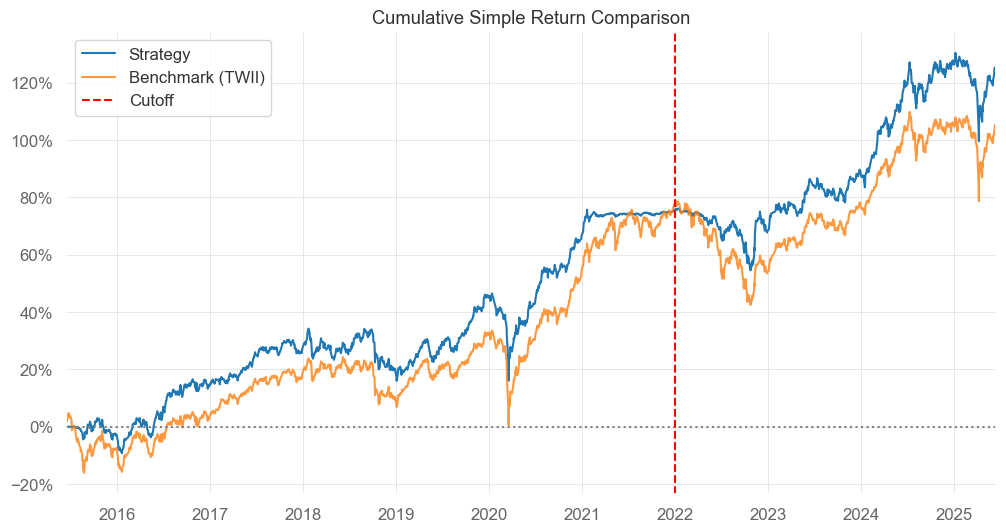

In [44]:
import matplotlib.ticker as mticker

# 計算大盤報酬
TWII_trade = mkt.copy()
TWII_trade['Return'] = TWII_trade['Close'].pct_change()
#TWII_trade['CumulativeReturn'] = (1 + TWII_trade['Return']).cumprod() - 1
TWII_trade['CumulativeReturn'] = TWII_trade['Return'].cumsum().fillna(0)
TWII_trade


firm_buyhold = data.copy()
firm_buyhold['Return'] = firm_buyhold['Close'].pct_change()
firm_buyhold['SimpleReturn'] = 1 + firm_buyhold['Return'].cumprod()


# 畫圖
plt.figure(figsize=(12, 6))
#plt.plot(trade['date'], trade['Cum Return'], label='Strategy', color = 'orange')
plt.plot(trade['date'], trade['CReturn_Eq'], label='Strategy', color = '#1f77b4')
plt.plot(TWII_trade['date'], TWII_trade['CumulativeReturn'], label='Benchmark (TWII)', color = '#ff7f0e', alpha=0.8)
#plt.plot(TSMC_buyhold['date'], TSMC_buyhold['SimpleReturn'], label='Buy & Hold')

# 加上買入標記
'''for i in range(0, len(buy_dates)):
    if i == 0:
        plt.axvline(x=buy_dates[i], color='#d62728', linestyle='--', alpha = 0.3, label = 'Buy')
    else:
        plt.axvline(x=buy_dates[i], color='#d62728', linestyle='--', alpha = 0.3)
for i in range(0, len(sell_dates)):
    if i == 0:
        plt.axvline(x=sell_dates[i], color='blue', linestyle='--', alpha = 0.3, label = 'Sell')
    else:
        plt.axvline(x=sell_dates[i], color='blue', linestyle='--', alpha = 0.3)'''
plt.xlim(trade['date'].iloc[0], trade['date'].iloc[-1])

plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

plt.axhline(0, color='gray', linestyle=':')
plt.axvline(x= cutoff, color = 'red', linestyle = '--', alpha = 1, label= 'Cutoff')

plt.legend(loc = 'upper left')
plt.title('Cumulative Simple Return Comparison')
plt.show()

In [45]:
TWII_trade

,date,Open,Close,market_momentum,stock_price_strength,stock_price_breadth,put_call_ratio,volatility,safe_haven_demand,Fear_Greed_Index,FGIEMA5,FGIEMA20,Return,CumulativeReturn
0,2014-09-23,9134.247819,9084.858398,29.365079,15.211640,7.671958,12.169312,9.126984,50.793651,20.723104,20.723104,20.723104,NaN,0.000000
1,2014-09-24,9071.757936,9098.448242,26.719577,19.841270,21.296296,12.169312,9.523810,48.941799,23.082011,22.138448,21.961530,0.001496,0.001496
2,2014-09-25,9126.718226,9011.548828,27.116402,26.984127,30.687831,12.566138,9.788360,34.259259,23.567019,22.815140,22.551056,-0.009551,-0.008055
3,2014-09-26,8957.518702,8989.779297,23.412698,7.407407,4.232804,10.317460,10.052910,41.534392,16.159612,20.050536,20.705945,-0.002416,-0.010471
4,2014-09-30,8954.539119,8966.878906,21.428571,6.481481,16.534392,6.084656,10.449735,26.587302,14.594356,17.955984,19.227604,-0.002547,-0.013018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2025-08-15,24266.230469,24334.480469,87.037037,57.142857,76.190476,80.158730,47.486772,52.380952,66.732804,62.322137,57.271465,0.003976,1.132364
2012,2025-08-19,24493.919922,24353.500000,89.153439,76.190476,89.417989,86.507937,46.560847,51.455026,73.214286,65.952853,58.789829,0.000782,1.133145
2013,2025-08-20,24309.269531,23625.439453,87.566138,22.288360,13.227513,88.425926,46.296296,66.005291,53.968254,61.957987,58.330631,-0.029896,1.103250
2014,2025-08-21,23739.830078,23962.130859,74.735450,12.433862,3.835979,83.994709,46.164021,71.957672,48.853616,57.589863,57.428058,0.014251,1.117501


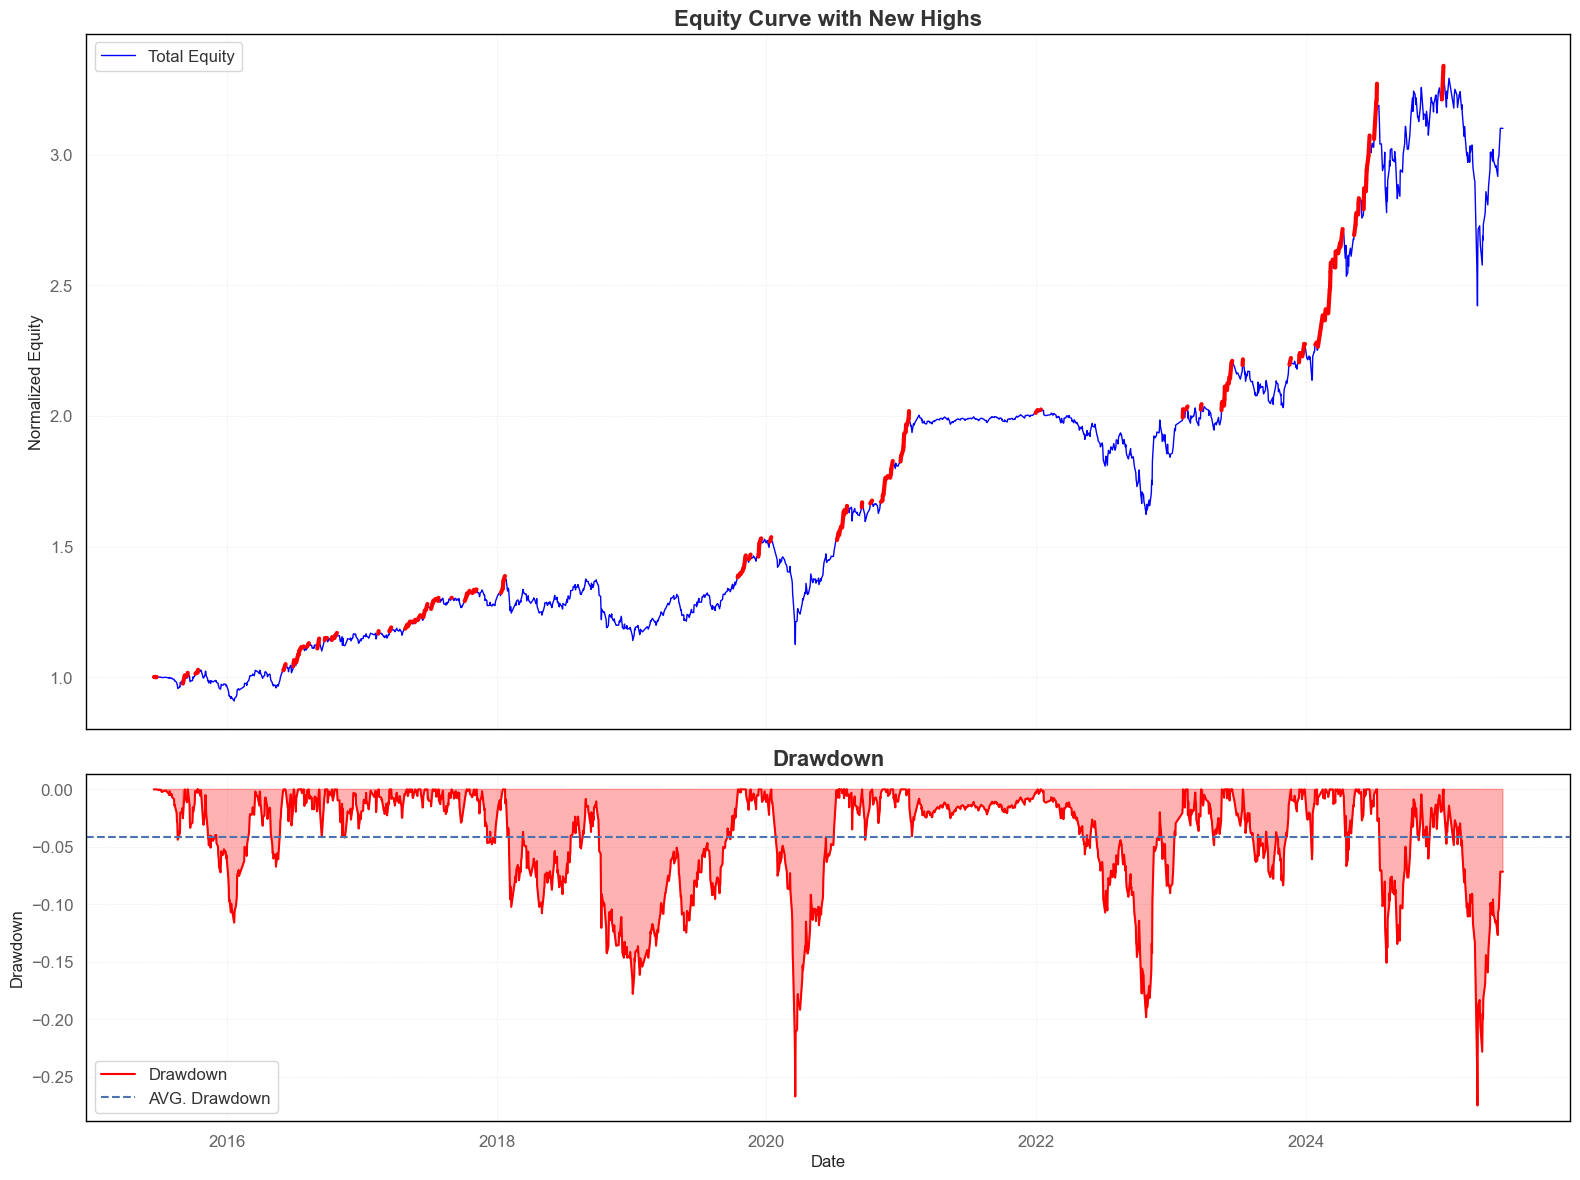

In [46]:
# 計算Equity Curve與DD
eq_curve = trade.copy()
eq_curve = eq_curve[['date', 'Equity']].copy()
eq_curve['Equity Growth'] = eq_curve['Equity'] / start_cash
eq_curve['Max Equity Growth'] = eq_curve['Equity Growth'].cummax()
eq_curve['Max Equity'] = eq_curve['Equity'].cummax()
eq_curve['Drawdown'] = (eq_curve['Equity'] - eq_curve['Max Equity'])/ eq_curve['Max Equity']
eq_curve['New High'] = eq_curve['Equity Growth'] == eq_curve['Max Equity Growth']
avg_drawdown = eq_curve['Drawdown'].mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# 繪製 Equity Curve & New High
ax1.plot(eq_curve['date'], eq_curve['Equity Growth'], color='blue', linewidth=1, label='Total Equity')
for i in range(1, len(eq_curve)):
    if eq_curve['New High'].iloc[i]:
        ax1.plot(eq_curve['date'].iloc[i-1:i+1], eq_curve['Equity Growth'].iloc[i-1:i+1],
                 color='red', linewidth=3)  # 標出創新高的線段
        
ax1.set_ylim(bottom=0.8)
ax1.set_title('Equity Curve with New Highs', fontsize=16, fontweight='bold')
ax1.set_ylabel('Normalized Equity', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()

# 繪製Drawdown 曲線
ax2.plot(eq_curve['date'], eq_curve['Drawdown'], color='red', label='Drawdown')

ax2.fill_between(eq_curve['date'], eq_curve['Drawdown'], 0, where=(eq_curve['Drawdown'] < 0), 
                 color='red', alpha=0.3)
ax2.set_title('Drawdown', fontsize=16, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Drawdown', fontsize=12)
ax2.axhline(y= avg_drawdown, linestyle='--', label='AVG. Drawdown')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()

for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

plt.tight_layout() 
plt.show()


# 參數最佳化

In [729]:
# 要稍微跑一下
def backtest_strategy(trade, fgi_entry, fgi_exit, rsi_entry, rsi_exit,
                      start_cash=1_500_000.00, unit_shares=1000, entry_window=30, entry_limit=1000):
    # 初始化欄位
    trade['Position'] = 0
    trade['Entry Signal'] = 0
    trade['Exit Signal'] = 0
    trade['Entry Record'] = 0
    trade['Exit Record'] = 0
    trade['Cum Return'] = 0.0
    trade['Unrealized_return'] = 0.0
    trade['Realized_return'] = 0.0
    trade['Total Cost'] = 0.0
    trade['Equity'] = start_cash
    trade['Cash'] = start_cash

    # 初始變數
    cash = start_cash
    cost = 0
    position = 0
    position_long_price = []
    realized_return = 0
    entry_record_window = deque()

    for i in range(1, len(trade)):
        pday = trade.iloc[i - 1]
        cday = trade.iloc[i]
        today = cday['date']

        # 限制進場次數
        entry_record_window = deque([d for d in entry_record_window if (today - d).days <= entry_window])
        overbuy_limited = len(entry_record_window) >= entry_limit

        # 進出場邏輯
        entry_signal = (cday['Fear_Greed_Index'] < fgi_entry) and (cday['RSI'] < rsi_entry)
        exit_signal = (cday['Fear_Greed_Index'] > fgi_exit) or (cday['RSI'] > rsi_exit)

        if entry_signal:
            trade.at[i, 'Entry Signal'] = 1
        if exit_signal:
            trade.at[i, 'Exit Signal'] = 1

        # 進場（加碼）
        if pday['Entry Signal'] == 1 and cash >= (cday['Open'] * unit_shares) and not overbuy_limited:
            trade.at[i, 'Entry Record'] = 1
            position += unit_shares
            cost += cday['Open'] * unit_shares
            cash -= cday['Open'] * unit_shares
            position_long_price.append(cday['Open'])
            entry_record_window.append(today)

        # 出場（減碼）
        if position > 0 and pday['Exit Signal'] == 1:
            position -= unit_shares
            trade.at[i, 'Exit Record'] = 1
            cash += cday['Open'] * unit_shares
            buy_price_tmp = position_long_price.pop(0)
            realized_return += (cday['Open'] - buy_price_tmp) * unit_shares

        # 最後一天全部出場
        elif i == len(trade) - 1 and position > 0:
            trade.at[i, 'Exit Record'] = 1
            cash += cday['Close'] * position
            for buy_price_tmp in position_long_price:
                realized_return += (cday['Close'] - buy_price_tmp) * unit_shares
            position = 0
            position_long_price = []

        # 未實現損益
        if position > 0 and len(position_long_price) > 0:
            avg_cost = sum(position_long_price) / len(position_long_price)
            unrealized_return = (cday['Close'] - avg_cost) * position
        else:
            unrealized_return = 0

        # 報酬率
        total_equity = cash + position * cday['Close']
        trade.at[i, 'Cum Return'] = (unrealized_return + realized_return) / cost if cost != 0 else 0
        trade.at[i, 'Position'] = position
        trade.at[i, 'Unrealized_return'] = unrealized_return
        trade.at[i, 'Realized_return'] = realized_return
        trade.at[i, 'Total Cost'] = cost
        trade.at[i, 'Equity'] = total_equity
        trade.at[i, 'Cash'] = cash

    # 回傳完整結果和績效指標
    daily_return = trade['Equity'].pct_change().fillna(0)
    sharpe_ratio = daily_return.mean() / daily_return.std() * np.sqrt(252) if daily_return.std() != 0 else 0

    return sharpe_ratio, trade['Equity'].iloc[-1]

from tqdm import tqdm
from itertools import product
# Grid Search (找最佳參數)
rsi_entry = 30
rsi_exit = 90
fgi_entry_range = np.arange(0, 30, 1)
fgi_exit_range = np.arange(75, 100, 1)

results = []
param_grid = list(product(fgi_entry_range, fgi_exit_range))

for fgi_entry, fgi_exit in tqdm(param_grid, desc="Grid Search", total=len(param_grid)):
    sharpe, equity = backtest_strategy(trade_in_sample, fgi_entry, fgi_exit, rsi_entry, rsi_exit)
    results.append({
        'fgi_entry': fgi_entry,
        'fgi_exit': fgi_exit,
        'sharpe': sharpe,
        'equity': equity
    })

results_df = pd.DataFrame(results)
results_df.to_csv("bestparam2.csv")


Grid Search: 100%|██████████| 750/750 [01:44<00:00,  7.18it/s]


In [27]:
results_df = pd.read_csv("bestparam2.csv")
results_df.drop(columns= 'Unnamed: 0', inplace= True)

最佳總資產報酬參數 (樣本內): FGI Entry:24, FGI Exit:91, Sharpe:1.0816297513310846


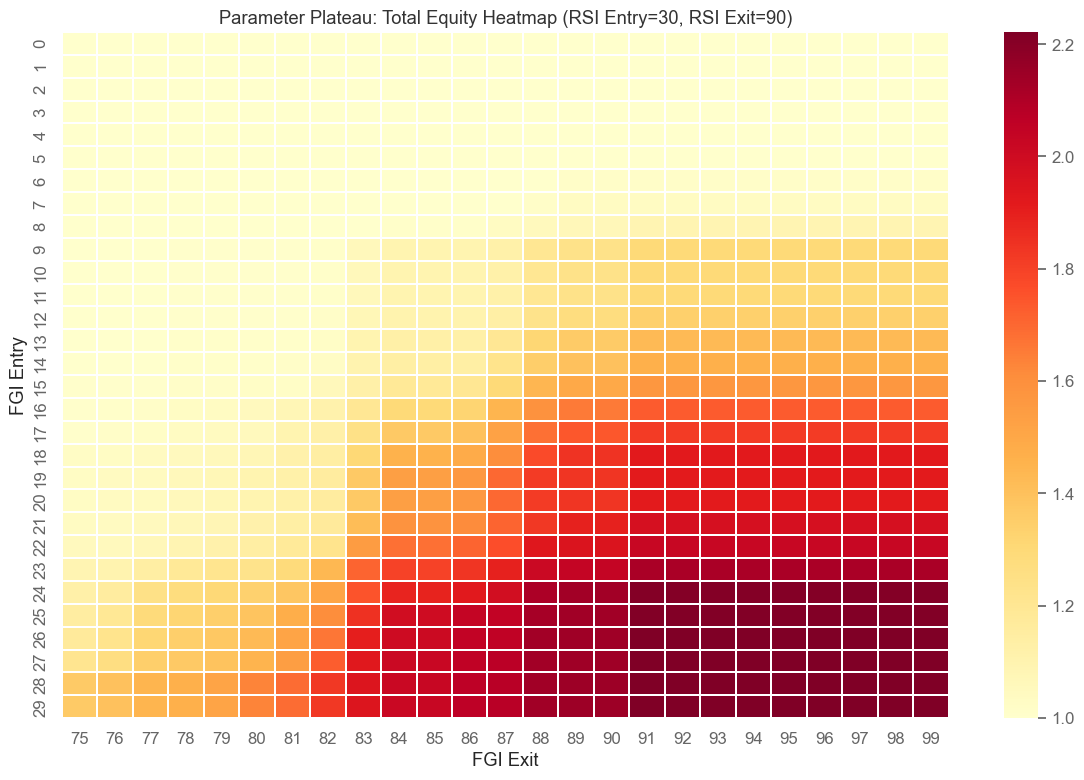

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd


best_result_eq = results_df['sharpe'].idxmax()  # 找出equity最大的組合index
best_result_eq
best_eq_entry = results_df.loc[best_result_eq, 'fgi_entry']
best_eq_exit = results_df.loc[best_result_eq, 'fgi_exit']
best_equity = results_df.loc[best_result_eq, 'equity']
best_sharpe = results_df.loc[best_result_eq, 'sharpe']

print(f'最佳總資產報酬參數 (樣本內): FGI Entry:{best_eq_entry}, FGI Exit:{best_eq_exit}, Sharpe:{best_sharpe}')

# 固定RSI Entry & Exit
fixed_rsi_entry = 30
fixed_rsi_exit = 90

filtered_df = results_df.copy()
filtered_df['equity'] = filtered_df['equity'].astype(float)
filtered_df['equity growth'] = filtered_df['equity']/ start_cash

heatmap_data = filtered_df.pivot(
    index='fgi_entry',
    columns='fgi_exit',
    values= 'equity growth'
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, fmt=".2f", cmap="YlOrRd", linewidths=0.2)

plt.title(f"Parameter Plateau: Total Equity Heatmap (RSI Entry={fixed_rsi_entry}, RSI Exit={fixed_rsi_exit})")
plt.xlabel("FGI Exit")
plt.ylabel("FGI Entry")
plt.tight_layout()
plt.show()

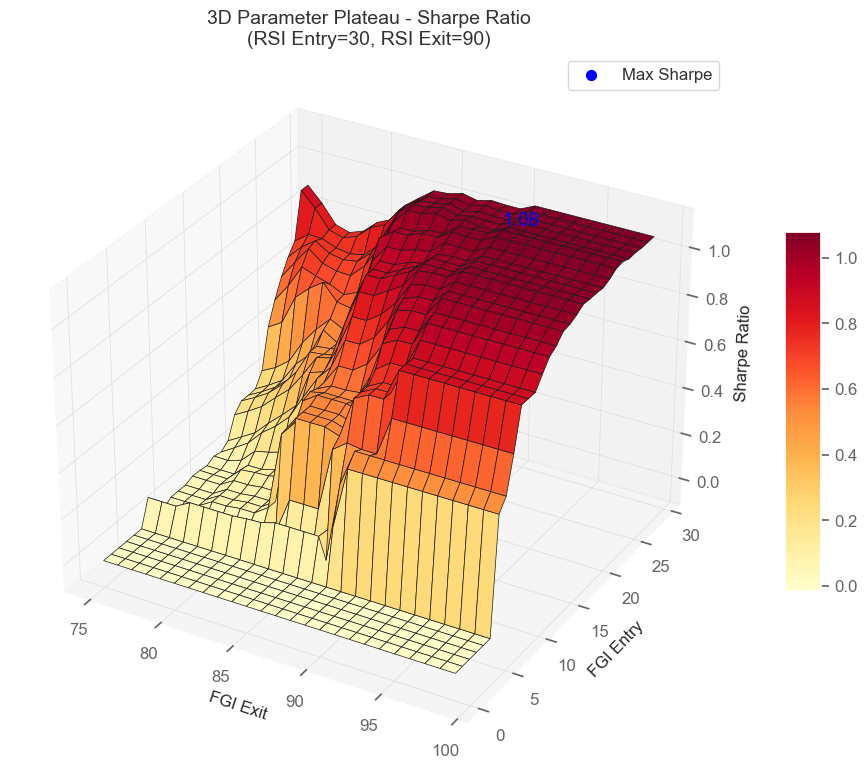

In [734]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

heatmap_data = filtered_df.pivot(index='fgi_entry', columns='fgi_exit', values='sharpe')

X = heatmap_data.columns.astype(float)
Y = heatmap_data.index.astype(float)
X, Y = np.meshgrid(X, Y)
Z = heatmap_data.values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='YlOrRd', edgecolor='k', linewidth=0.5, antialiased=True)

# 軸與標題
ax.set_title(f"3D Parameter Plateau - Sharpe Ratio\n(RSI Entry={fixed_rsi_entry}, RSI Exit={fixed_rsi_exit})", fontsize=14)
ax.set_xlabel("FGI Exit", fontsize=12)
ax.set_ylabel("FGI Entry", fontsize=12)
ax.set_zlabel("Sharpe Ratio", fontsize=12)

# 最大值標記
max_idx = np.unravel_index(np.nanargmax(Z), Z.shape)
max_x, max_y, max_z = X[max_idx], Y[max_idx], Z[max_idx]
ax.scatter(max_x, max_y, max_z, color='blue', s=50, label='Max Sharpe')
ax.text(max_x, max_y, max_z + 0.02, f'{max_z:.2f}', color='blue')
ax.legend()

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()


# 其他回測圖表

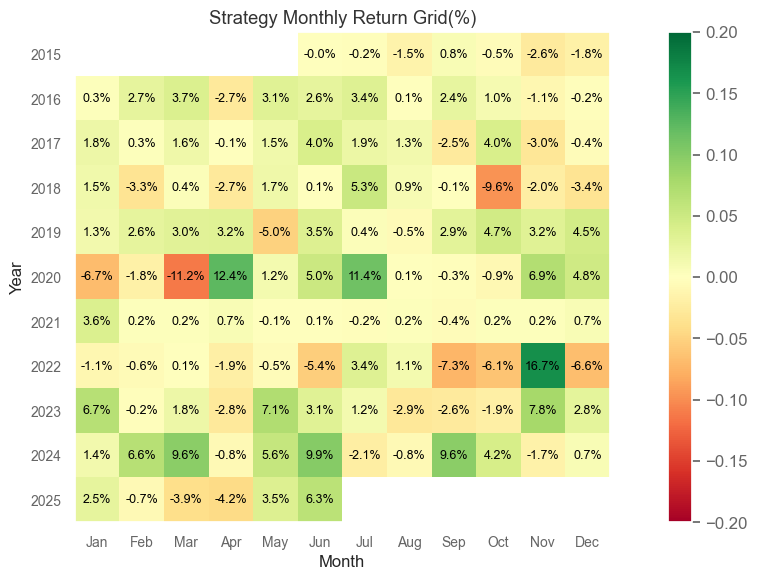

In [ ]:
# 月報酬熱力圖
df = trade_all.copy()
df['date'] = pd.to_datetime(df['date'])
df['Daily Return'] = df['Equity'].pct_change()
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month


# 計算每月報酬
monthly_returns = df.groupby(['Year', 'Month'])['Equity'].apply(lambda x: x.iloc[-1] / x.iloc[0] - 1)
monthly_returns
pivot_table = monthly_returns.unstack()

# 繪製熱力圖
plt.figure(figsize=(12, 6))
im = plt.imshow(pivot_table, cmap="RdYlGn", vmin=-0.2, vmax=0.2)

for i in range(pivot_table.shape[0]):
    for j in range(pivot_table.shape[1]):
        value = pivot_table.iloc[i, j]
        if pd.notna(value):
            plt.text(j, i, f"{value:.1%}", ha='center', va='center', fontsize=9, color="black")

# 設定軸標籤
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(12), [f"{m}" for m in months], fontsize=10)
plt.yticks(range(len(pivot_table.index)), pivot_table.index.get_level_values(0), fontsize=10)
plt.colorbar(im)
plt.title("Strategy Monthly Return Grid(%)")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Year", fontsize=12)
plt.tight_layout()
plt.grid(False)

plt.show()

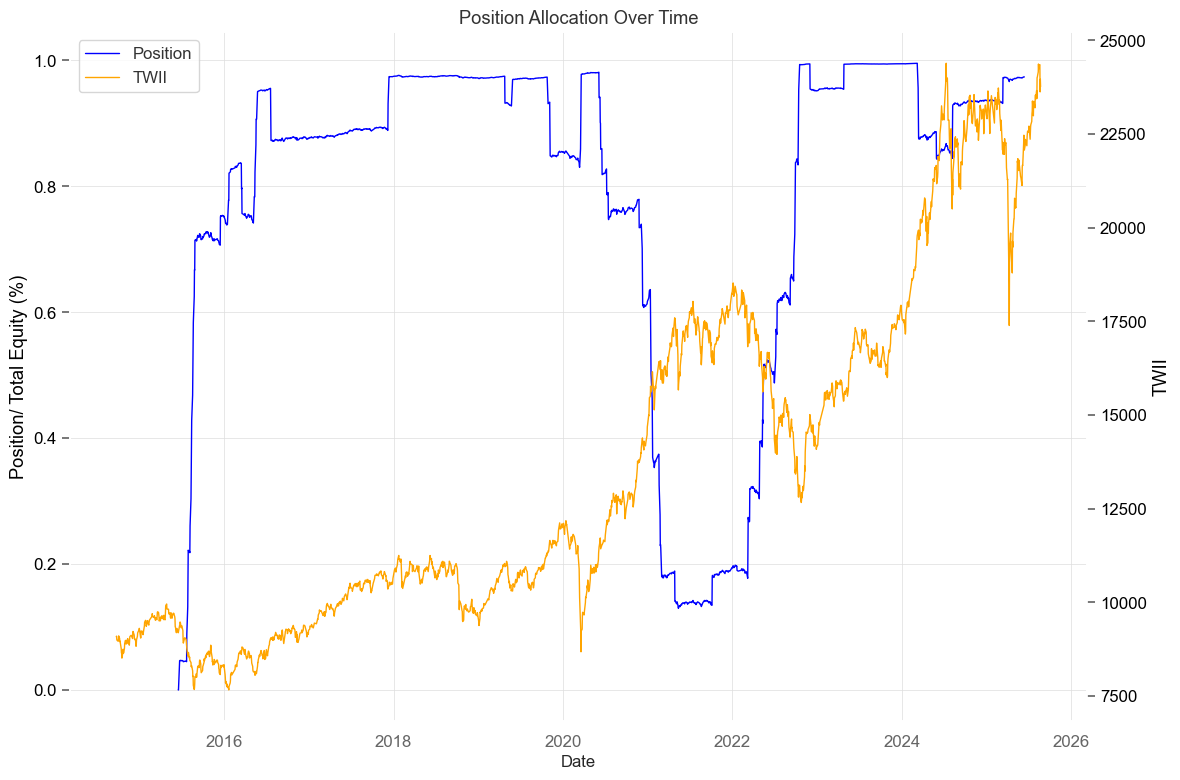

In [ ]:
# 部位vs.總資產比例圖表
trade_df = trade_all.copy()
trade_df = trade_df[:-1]  # 移除最後一日強制平倉的
trade_df['Pos Ratio'] = trade_df['Position'] * trade_df['Close']/trade_df['Equity']
trade_df['Cash Ratio'] = trade_df['Cash']/trade_df['Equity']

# 計算大盤報酬
TWII_trade = mkt.copy()
TWII_trade['Return'] = TWII_trade['Close'].pct_change()
TWII_trade['CumulativeReturn'] = TWII_trade['Return'].cumsum().fillna(0)
TWII_trade

fig, ax1 = plt.subplots(figsize=(12, 8))

line1,= ax1.plot(trade_df['date'], trade_df['Pos Ratio'], label = 'Position', color= 'blue', linewidth = 1)
ax1.set_ylabel("Position/ Total Equity (%)", color='black')
ax1.set_xlabel("Date", fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
line2,= line2, = ax2.plot(mkt['date'], mkt['Close'], label='TWII', color='orange', linewidth=1)
ax2.set_ylabel("TWII", color='Black')
ax2.tick_params(axis='y', labelcolor='Black')

lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title("Position Allocation Over Time")

plt.tight_layout()
plt.grid(False)

C:\Users\Sean\AppData\Local\Temp\ipykernel_42464\1275390312.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


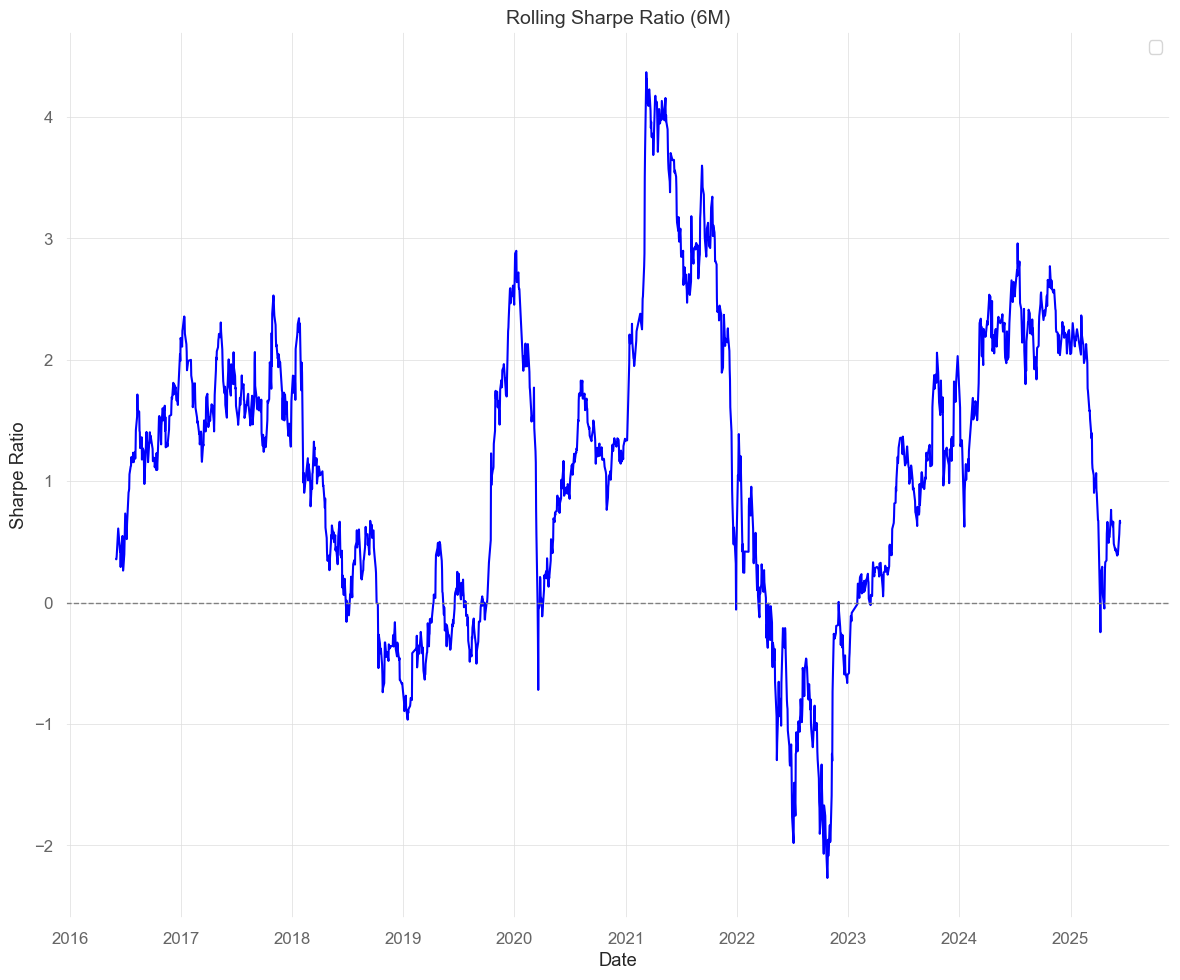

In [83]:
# 滾動Sharpe Ratio圖表
df = trade_all.copy()
trade_df['Return'] = trade_df['Equity'].pct_change().fillna(0)
rolling_window = 180

# 年化因子
annual_factor = np.sqrt(252)

# 避免除以 0，設個極小值
eps = 1e-8

# Rolling Sharpe
trade_df['Rolling Sharpe'] = (
    trade_df['Return'].rolling(rolling_window).mean() /(trade_df['Return'].rolling(rolling_window).std() + eps)) * annual_factor

plt.figure(figsize=(12, 10))
plt.plot(trade_df['date'], trade_df['Rolling Sharpe'], color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Rolling Sharpe Ratio (6M)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()